In [ ]:
#spacy
import spacy
import en_core_web_lg
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc, Span
from spacy.matcher import Matcher, PhraseMatcher 
#from scripts.spacy_model import load_results_auto, load_results_manual

#Visualization
from spacy import displacy
#import pyLDAvis.gensim_models
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#Data loading/ Data manipulation
import pandas as pd
import numpy as np
import jsonlines
import json
import os
import csv
import re
import sys

#nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])

import time
#warning
import warnings 
warnings.filterwarnings('ignore')

In [14]:
PATH = os.path.dirname(os.getcwd())
PATH

'/home/lewagonlew/code/marcorodrigues/skills_matcher'

In [18]:
os.chdir(PATH)

In [19]:
os.getcwd()

'/home/lewagonlew/code/marcorodrigues/skills_matcher'

In [20]:
%load_ext autoreload
%autoreload 2
from skills_matcher.scripts.spacy_model import load_results_auto, load_results_manual
from skills_matcher.scripts.utils.clean_skills import extract_skills_auto, extract_entities_2, extract_lables, get_dict, get_dict_cv
from skills_matcher.scripts.utils.paths import load_paths

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
PATH_DATA, PATH_DICT, PATH_TRAIN_DATA, PATH_VAL_DATA, PATH_COMPLETE_DICT = load_paths('data_final_raw', 'doccano_dictionary', 'train', 'val', 'complete_dict')

In [25]:
#resume data from kaggle - for tryout
df = pd.read_csv("cleaned_Resume.csv")
df

,Unnamed: 0,index,Resume_str,Resume_html,Category,Clean_Resume,entities_auto_label,entities_manual_label,entity_ruler
0,0,0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr administrator marketing associate hr admini...,"(medium, medium)",[],"{'front end', 'data analysis', 'marketing', 'a..."
1,1,1,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,hr specialist u hr operation summary versatile...,"(medium, medium, medium, medium, medium)",[],"{'marketing', 'software', 'material', 'project..."
2,2,2,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr director summary 20 year experience recruit...,"(publishing,)",[],"{'monitoring', 'publishing', 'marketing', 'dat..."
3,3,3,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr specialist summary dedicated driven dynamic...,(),[],"{'monitoring', 'database', 'business administr..."
4,4,4,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr manager skill highlight hr skill hr departm...,(),"[{'entity': recruit, 'label': 'KNOWLEDGE'}, {'...","{'business administration', 'impact', 'project..."
...,...,...,...,...,...,...,...,...,...
995,995,995,SALES Summary I am looking f...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale summary looking career position company r...,(),[],"{'business', 'marketing', 'security', 'support'}"
996,996,996,SALES Summary Self-motivated...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale summary self motivated individual offerin...,(),[],"{'sap', 'accounting', 'business', 'certificate..."
997,997,997,SALES Summary General Sales...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale summary general sale manager offering 17 ...,(),[],"{'monitoring', 'marketing', 'accounting', 'sch..."
998,998,998,SALES Professional Summary ...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale professional summary graduated earle high...,"(go, florida)",[],"{'collaboration', 'go', 'material', 'documenta..."


In [26]:
df.shape

(1000, 9)

In [ ]:
df["Clean_Resume"] = clean_resume(df)
df["marked_text"] = df["Clean_Resume"].str.lower().apply(nlp_ms)
df["skills"] = df["marked_text"].apply(create_skill_list)
df.reset_index(inplace = True)
df.head()

In [ ]:
test_resume = nlp_ms(df["Resume_str"].iloc[0])
resume_ents = [(ent.text, ent.label_) for ent in test_resume.ents]
displacy.render(test_resume, style="ent", jupyter=True)
print(resume_ents)

In [3]:
#functions for getting entities text, label, start and end of character position
def create_skill_set(text, model = False):
    '''Apply basic spacy model and Create a set of the extracted skill entities'''
    
    if model == True:
        nlp_ms = spacy.blank("en")
        skill_pattern_path = PATH + "/data/dictionaries/complete_dict.jsonl"
        ruler = nlp_ms.add_pipe("entity_ruler")
        ruler.from_disk(skill_pattern_path)
        doc = nlp(text)
        
    return set([ent.label_.upper()[6:] for ent in doc.ents if 'skill' or 'knowledge' in ent.label_.lower()])

def create_skill_position(doc):
    '''Create a set of the extracted skill entities of a doc'''
    #nlp_doc = nlp_ms(doc)
    #[(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in sent.ents]
    return list([ent.start_char, ent.end_char, ent.label_] for ent in doc.ents )

#def create_skillset_dict(resume_texts):
#    '''Create a dictionary containing a set of the extracted skills. Name is key, matching skillset is value'''
#    skillsets = [create_skill_set(resume_text) for resume_text in resume_texts]
#   return skillsets

def create_skill_list(text, model = False):
    
    if model == True:
        nlp_ms = spacy.blank("en")
        skill_pattern_path = PATH + "/data/dictionaries/complete_dict.jsonl"
        ruler = nlp_ms.add_pipe("entity_ruler")
        ruler.from_disk(skill_pattern_path)
        doc = nlp_ms(text)
    
    t = list([ent.text] for ent in doc.ents )
    flat_list = [item for sublist in t for item in sublist]
    return set(flat_list)

def match_skills(JD_data_set, cv_set):
    '''Get intersection of resume skills and job offer skills and return match percentage'''
    pct_list = []
    
    if len(cv_set) < 1:
        print('could not extract skills from resume text')   
    else:
        #implement function comparing with a list of job_descriptions
        for i in range(0, len(JD_set)):
            match = cv_set & JD_set[i] 
            qu = len(cv_set & JD_set[i])
            di = len(JD_set[i])
            pct_match = round((qu/di) * 100, 2)
            pct_list.append([i, pct_match])
            
        pct_list.sort(key=lambda x: x[1], reverse = True)
    
        #print("Resume has a {}% skill match on job offer".format(pct_match))
        #print('Required skills: {} '.format(JD_set))
        #print('Matched skills: {} \n'.format(JD_set.intersection(skillset_dict[resume_name])))
        
    return pct_list[0:9]

In [ ]:
# compare df.skills with test_list
cv_set = test_list
JD_set = df.skills
pct_list = match_skills(JD_set, cv_set)

In [ ]:
df.shape()

In [ ]:
pct_list = match_skills(JD_set, cv_set)

In [ ]:
job_number, matching_score, job_cat = [], [], []
frame = pd.DataFrame

for i in pct_list:
    cat = df["Category"][i[0]]
    print('Job #{} in Sector {} has a {}% match'.format(i[0], df["Category"][i[0]], i[1]))
    job_number.append(i[0])
    matching_score.append(i[1])
    
    if cat in job_cat:
        job_cat.append(str(cat) + str(i[0]))
    else:
        job_cat.append(cat)
    
frame = pd.DataFrame(job_number, columns=['job_number'])
frame["matching_score"] = matching_score
frame["Category"] = job_cat
frame["color"][0:2] = 'rgb(240,150,255)'
frame["color"][2:5] = 'blue'
frame["color"][5:8] = 'yellow'
frame["color"][8:] = 'red'

In [ ]:
frame

In [ ]:
## compare list with data_set, visualize highest matching jobs
job_number, matching_score, job_cat = [], [], []
frame = pd.DataFrame

for i in pct_list:
    cat = df["Category"][i[0]]
    print('Job #{} in Sector {} has a {}% match'.format(i[0], df["Category"][i[0]], i[1]))
    job_number.append(i[0])
    matching_score.append(i[1])
    
    if cat in job_cat:
        job_cat.append(str(cat) + str(i[0]))
    else:
        job_cat.append(cat)
    
frame = pd.DataFrame(job_number, columns=['job_number'])
frame["matching_score"] = matching_score
frame["Category"] = job_cat


#for template in ["ggplot2", "seaborn"]:
import plotly.graph_objects as go

fig = px.bar(
    x=frame['Category'], 
    y=frame["matching_score"],
    labels={"x": "job position", "y": "Matching %"},
    title=f"Job offers matching with resume",
    width=1200, height=800,
    template="seaborn",
    color = frame["matching_score"])
fig.update_layout(
        #margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="lightblue",
)
fig.show()

In [ ]:
## comparison of test_resume with automated_annotated_JD data

## Loading Data with pre-trained Spacy Model (Auto/Manual)

In [10]:
PATH = os.path.dirname(os.getcwd()) + "/skills_matcher"
PATH

'/home/lewagonlew/code/marcorodrigues/skills_matcher/skills_matcher'

In [32]:
PATH_COMPLETE_DICT

'/home/lewagonlew/code/marcorodrigues/skills_matcher/skills_matcher/data/dictionaries/complete_dict.jsonl'

In [71]:
df_JD = pd.read_csv(PATH_DATA)
df_JD.head()

,Unnamed: 0,ISCO,major_job,job,position,location,description,entities_auto_label,entities_manual_label
0,0,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Accelerator Physicist id54315,"Villigen PSI, Aargau",[' You have an academic degree in physics or e...,(),"[{'entity': physics, 'label': 'KNOWLEDGE'}, {'..."
1,1,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Accelerator Physicist id54315,"Villigen PSI, Aargau",[' You have an academic degree in physics or e...,(),"[{'entity': RICS, 'label': 'SKILL'}, {'entity'..."
2,2,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Accelerator Physicist id54315,"Villigen PSI, Aargau",[' You have an academic degree in physics or e...,(),"[{'entity': CIS, 'label': 'SKILL'}, {'entity':..."
3,3,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Applied Physicist (Computing) (EP-LBC-2021-125...,Geneva,[' Be in charge of the development of applicat...,"(Python, Python)","[{'entity': Python, 'label': 'SKILL'}, {'entit..."
4,4,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Applied Physicist (Computing) (EP-LBC-2021-125...,Geneva,[' Be in charge of the development of applicat...,"(Python, Python)",[]


In [ ]:
df_JD.shape

In [ ]:
df_JD.drop(columns = ["major_job", "ISCO", "location"], inplace = True)

# Resume data

In [7]:
os.chdir('/home/lewagonlew/code/marcorodrigues/skills_matcher')

In [8]:
os.getcwd()

'/home/lewagonlew/code/marcorodrigues/skills_matcher'

In [ ]:
df_Resume_1.pd.read_csv("cleaned_Resume_part_2.csv")

In [35]:
df_Resume = pd.read_csv("/home/lewagonlew/code/marcorodrigues/skills_matcher/skills_matcher/data/Resume/Resume.csv")
df_Resume.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [36]:
# talking smaller, randomized subsample
#df_Resume = df_Resume.reindex(np.random.permutation(df_Resume.index))
df_Resume = df_Resume.copy().iloc[
    1000:,
]
df_Resume.head()

,ID,Resume_str,Resume_html,Category
1000,40987524,SALES Summary Over 17 years ...,"<div class=""fontsize fontface vmargins hmargin...",SALES
1001,29134721,SALES Career Overview Durin...,"<div class=""fontsize fontface vmargins hmargin...",SALES
1002,18062906,SALES Summary Extremely ...,"<div class=""fontsize fontface vmargins hmargin...",SALES
1003,29399491,SALES Professional Summary I...,"<div class=""fontsize fontface vmargins hmargin...",SALES
1004,19473948,SALES Summary OFFICE & CUSTO...,"<div class=""fontsize fontface vmargins hmargin...",SALES


In [38]:
%%time
df_Resume["Clean_Resume"] = clean_resume(df_Resume)
df_Resume.head()

CPU times: user 1min 56s, sys: 7.98 s, total: 2min 4s
Wall time: 2min 4s


,ID,Resume_str,Resume_html,Category,Clean_Resume
1000,40987524,SALES Summary Over 17 years ...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale summary 17 year sale operation management...
1001,29134721,SALES Career Overview Durin...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale career overview course career professiona...
1002,18062906,SALES Summary Extremely ...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale summary extremely loyal ambitious hard wo...
1003,29399491,SALES Professional Summary I...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale professional summary want challenging occ...
1004,19473948,SALES Summary OFFICE & CUSTO...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale summary office customer service experienc...


In [55]:
df_Resume.to_csv("cleaned_Resume_2.csv")

In [39]:
df_Resume.shape

(1484, 5)

In [ ]:
%%time
#applying trained models on resume dataset
#df_Resume['entities_auto_label'] = df_Resume.Clean_Resume.apply(load_results_auto)
df_Resume['entities_manual_label'] = df_Resume.Clean_Resume.apply(load_results_manual)
df_Resume.reset_index(inplace = True)
df_Resume

In [ ]:
%%time
#applying base model on resum dataset
df_Resume["marked_text"] = df_Resume["Clean_Resume"].str.lower().apply(nlp_ms)
df_Resume["entity_ruler"] = df_Resume["marked_text"].apply(create_skill_list)
df_Resume.reset_index(inplace = True)
df_Resume

In [ ]:
df_Resume.drop(columns = ["level_0", "index", "ID", "marked_text"], inplace = True)
df_Resume.reset_index(inplace = True)
df_Resume.head()

In [67]:
df_Resume

,ID,Resume_str,Resume_html,Category,Clean_Resume,entities_auto_label
1000,40987524,SALES Summary Over 17 years ...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale summary 17 year sale operation management...,()
1001,29134721,SALES Career Overview Durin...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale career overview course career professiona...,"((linux),)"
1002,18062906,SALES Summary Extremely ...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale summary extremely loyal ambitious hard wo...,()
1003,29399491,SALES Professional Summary I...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale professional summary want challenging occ...,()
1004,19473948,SALES Summary OFFICE & CUSTO...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale summary office customer service experienc...,()
...,...,...,...,...,...,...
2479,99416532,RANK: SGT/E-5 NON- COMMISSIONED OFFIC...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION,rank sgt e 5 non commissioned officer charge b...,()
2480,24589765,"GOVERNMENT RELATIONS, COMMUNICATIONS ...","<div class=""fontsize fontface vmargins hmargin...",AVIATION,government relation communication organization...,"((medium), (medium), (medium), (medium), (medi..."
2481,31605080,GEEK SQUAD AGENT Professional...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION,geek squad agent professional profile support ...,"((android),)"
2482,21190805,PROGRAM DIRECTOR / OFFICE MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION,program director office manager summary highly...,"((medium), (medium))"


In [ ]:
data_CV = df_Resume.apply(get_dict_cv, axis=1)

In [125]:
def extract_resume_skills(text):
    
    #model set to False if nlp models (base, trained) were already applied. Set to true if not
    set_list_2 = []
    ext = []
    
    list_1 = create_skill_list(text, model = True)  #get extracted skills with base_model
    list_2 = load_results_manual(text)     #get extracted skills with trained_model  
        
    for i in range(0, len(list_2)):
        set_list_2.append(str(list_2[i]["entity"]).lower().strip())
    set_list_2 = set(set_list_2)
    ext.append(set.union(list_1, set_list_2))
    
    flat_list = [item for sublist in ext for item in sublist]
    set(flat_list)
        
    return flat_list

In [109]:
skill_list = extract_resume_skills(text, model = True)

In [110]:
skill_list

['data visualization',
 'swiss',
 'keras',
 'material',
 'data science',
 'ms office',
 'matura',
 'notary',
 'activities',
 'heroku',
 'english',
 'devops',
 'communications',
 'customer relationship management',
 'engineering',
 'languages',
 'r',
 'san diego/',
 'interests',
 'word',
 'tensorflow',
 'finance',
 'business',
 'economics',
 'machine learning',
 'blockchain',
 'visualization',
 'sql',
 'personal',
 'internship',
 'shanghai',
 'mathematics',
 'pandas',
 'german',
 'gcp',
 'mlflow',
 'student',
 'statistics\n           09/2017-12/2020',
 '1-6)',
 'python',
 'excel',
 'basel',
 'experience',
 'ag',
 'support',
 'cloud',
 'tensorflow keras',
 'deep learning',
 'seaborn',
 'nlp',
 'data analysis',
 'scikit',
 'optravis llc',
 'ai',
 'game theory',
 'marketing',
 'numpy',
 'agile & devops',
 'switzerland',
 'east',
 'tq']

In [72]:
df_JD

,Unnamed: 0,ISCO,major_job,job,position,location,description,entities_auto_label,entities_manual_label
0,0,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Accelerator Physicist id54315,"Villigen PSI, Aargau",[' You have an academic degree in physics or e...,(),"[{'entity': physics, 'label': 'KNOWLEDGE'}, {'..."
1,1,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Accelerator Physicist id54315,"Villigen PSI, Aargau",[' You have an academic degree in physics or e...,(),"[{'entity': RICS, 'label': 'SKILL'}, {'entity'..."
2,2,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Accelerator Physicist id54315,"Villigen PSI, Aargau",[' You have an academic degree in physics or e...,(),"[{'entity': CIS, 'label': 'SKILL'}, {'entity':..."
3,3,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Applied Physicist (Computing) (EP-LBC-2021-125...,Geneva,[' Be in charge of the development of applicat...,"(Python, Python)","[{'entity': Python, 'label': 'SKILL'}, {'entit..."
4,4,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Applied Physicist (Computing) (EP-LBC-2021-125...,Geneva,[' Be in charge of the development of applicat...,"(Python, Python)",[]
...,...,...,...,...,...,...,...,...,...
3502,3502,22,HEALTH PROFESSIONALS,veterinary surgeon,Veterinary Surgeon,England,[' Allocated CPD funding of 37.5 hours Excelle...,(),"[{'entity': driving licence, 'label': 'KNOWLED..."
3503,3503,22,HEALTH PROFESSIONALS,veterinary surgeon,Permanent Veterinary Surgeon,"Cricklewood, North West London",[' Type: Small Animal Hours: Monday - Friday 4...,(),"[{'entity': driver's license, 'label': 'KNOWLE..."
3504,3504,22,HEALTH PROFESSIONALS,veterinary surgeon,Veterinary Surgeon,"Middlesbrough, North Yorkshire","[' Allocated CPD funding of 37.5 hours ', ' 5 ...",(),"[{'entity': driver's license, 'label': 'KNOWLE..."
3505,3505,22,HEALTH PROFESSIONALS,veterinary surgeon,Permanent Veterinary Surgeon,"Harrogate, North Yorkshire","["" Experienced required: New Graduate level to...",(),"[{'entity': driver's license, 'label': 'KNOWLE..."


In [73]:
data_cleaned = df_JD.apply(get_dict, axis=1)

In [ ]:
data_CV = df_Resume.apply(get_dict_cv, axis=1)

In [130]:
data_cleaned.job.unique()

array(['physicist', 'biochemist', 'chemist', 'organic chemist',
       'process chemist', 'geologist', 'hydrogeologist',
       'biostatistician', 'mathematician', 'statistician', 'biologist',
       'geneticist', 'immunologist', 'microbiologist',
       'molecular biologist', 'physiologist', 'toxicologist', 'ecologist',
       'verification engineer', 'construction planner',
       'development engineer', 'inspection engineer', 'plant engineer',
       'process engineer', 'product developer', 'project engineer',
       'environmental engineer', 'instrument engineer',
       'maintenance engineer', 'mechanical designer',
       'mechanical engineer', 'mechatronics engineer', 'testing engineer',
       'audit assistant', 'bookkeeper', 'inspector',
       'field sales representative', 'buyer', 'conference manager',
       'manager', 'administrative assistant', 'geography teacher',
       'primary school teacher', 'supply teacher',
       'special needs teacher', 'speech therapist', 'lang

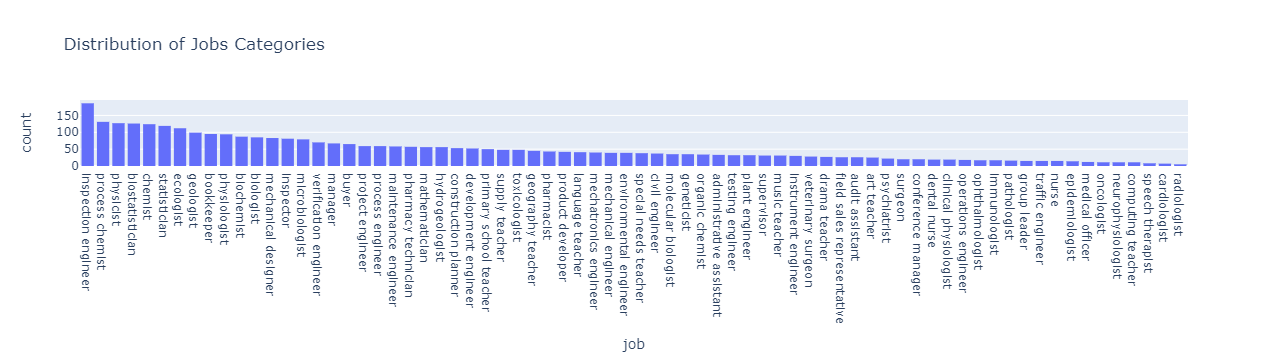

In [131]:
fig = px.histogram(
    data_cleaned, x="job", title="Distribution of Jobs Categories"
).update_xaxes(categoryorder="total descending")
fig.show()

In [132]:
data_cleaned

,Unnamed: 0,ISCO,major_job,job,position,location,description,entities_auto_label,entities_manual_label,SKILL,KNOWLEDGE,MIN_EXP,LEVEL
0,0,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Accelerator Physicist id54315,"Villigen PSI, Aargau",[' You have an academic degree in physics or e...,(),"[{'entity': physics, 'label': 'KNOWLEDGE'}, {'...","[English, German]",[physics],[],[]
1,1,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Accelerator Physicist id54315,"Villigen PSI, Aargau",[' You have an academic degree in physics or e...,(),"[{'entity': RICS, 'label': 'SKILL'}, {'entity'...","[RICS, CABE, driving licence]",[],[],[]
2,2,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Accelerator Physicist id54315,"Villigen PSI, Aargau",[' You have an academic degree in physics or e...,(),"[{'entity': CIS, 'label': 'SKILL'}, {'entity':...",[CIS],[Fawkes],[],[]
3,3,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Applied Physicist (Computing) (EP-LBC-2021-125...,Geneva,[' Be in charge of the development of applicat...,"(Python, Python)","[{'entity': Python, 'label': 'SKILL'}, {'entit...","[Python, English, French]","[programming, High Energy Physics data analysi...",[],[]
4,4,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Applied Physicist (Computing) (EP-LBC-2021-125...,Geneva,[' Be in charge of the development of applicat...,"(Python, Python)",[],[Python],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3502,3502,22,HEALTH PROFESSIONALS,veterinary surgeon,Veterinary Surgeon,England,[' Allocated CPD funding of 37.5 hours Excelle...,(),"[{'entity': driving licence, 'label': 'KNOWLED...",[],[driving licence],[],[]
3503,3503,22,HEALTH PROFESSIONALS,veterinary surgeon,Permanent Veterinary Surgeon,"Cricklewood, North West London",[' Type: Small Animal Hours: Monday - Friday 4...,(),"[{'entity': driver's license, 'label': 'KNOWLE...",[],[driver's license],[],[]
3504,3504,22,HEALTH PROFESSIONALS,veterinary surgeon,Veterinary Surgeon,"Middlesbrough, North Yorkshire","[' Allocated CPD funding of 37.5 hours ', ' 5 ...",(),"[{'entity': driver's license, 'label': 'KNOWLE...",[],[driver's license],[],[]
3505,3505,22,HEALTH PROFESSIONALS,veterinary surgeon,Permanent Veterinary Surgeon,"Harrogate, North Yorkshire","["" Experienced required: New Graduate level to...",(),"[{'entity': driver's license, 'label': 'KNOWLE...",[],[driver's license],[],[]


In [ ]:
data_cleaned.loc[df_JD['job'] == 'mathematician', ['job', 'position', 'location', 'description',	
                              'entities_auto_label', 'entities_manual_label']]

In [241]:
def extract_jd(inp = None):
    df_JD = pd.read_csv(PATH_DATA)
    
    if inp == None:
        data = df_JD.apply(get_dict, axis=1)
        data.drop(columns = ["ISCO", "major_job"], inplace = True)
    else:    
        df_JD = df_JD.loc[df_JD['job'] == inp, ['job', 'position', 'location', 'description',	
                              'entities_auto_label', 'entities_manual_label']]
        data = df_JD.apply(get_dict, axis=1)
        data.reset_index(inplace = True)
        
    data.drop(columns = ['entities_auto_label', 'entities_manual_label'], inplace = True)
    
    return data

In [276]:
inp = 'chemist'

In [277]:
data = extract_jd(inp)
JD_set = data["SKILL"].apply(set)
data.head()

,index,job,position,location,description,SKILL,KNOWLEDGE,MIN_EXP,LEVEL
0,214,chemist,Senior Process Chemist / Agrochemicals,Germany,[' Stable and growing business|Great opportuni...,[NDVI],[],[],[]
1,215,chemist,Senior Process Chemist / Agrochemicals,Germany,[' Stable and growing business|Great opportuni...,"[CyberSecurity, communication, English, French...","[Information Technology management, IT, civil ...",[Agile],[Master's]
2,216,chemist,Senior Process Chemist / Agrochemicals,"Leipzig, Sachsen",[' Stable and growing business|Great opportuni...,[],"[chemistry, agro, chemical industry]",[R&D],[]
3,217,chemist,Senior Process Chemist / Agrochemicals,"Leipzig, Sachsen",[' Stable and growing business|Great opportuni...,[],[],[English],[]
4,218,chemist,Senior Process Chemist / Agrochemicals,"Leipzig, Sachsen",[' Stable and growing business|Great opportuni...,"[English, Dutch]",[accountancy],[],[degree]


In [278]:
JD_set

0                                                 {NDVI}
1      {communication, CyberSecurity, Dutch, English,...
2                                                     {}
3                                                     {}
4                                       {Dutch, English}
                             ...                        
119    {Outlook, PowerPoint, Excel, Visio, MS Office ...
120                                           {SQL, SAP}
121                                           {AAS, AES}
122    {CRM, MS systems, Outlook Microsoft Dynamics, ...
123    {PowerPoint, VLOOKUP, pivot tables, Hyperion P...
Name: SKILL, Length: 124, dtype: object

In [279]:
(data["SKILL"].map(len)).max()

9

In [280]:
pct_list = []
    
JD_set = list(filter(None, JD_set))

for i in range(0, len(JD_set)):
            if len(JD_set) == 0:
                continue
            match = set(cv_set) & JD_set[i] 
            #print(match)
            qu = len(set(cv_set) & JD_set[i])
            di = len(JD_set[i])
            pct_match = round((qu/di) * 100, 2)
            pct_list.append([i, pct_match])
            
pct_list.sort(key=lambda x: x[1], reverse = True)
#pct_list = pct_list[0:10]

pct_list

[[0, 0.0],
 [1, 0.0],
 [2, 0.0],
 [3, 0.0],
 [4, 0.0],
 [5, 0.0],
 [6, 0.0],
 [7, 0.0],
 [8, 0.0],
 [9, 0.0],
 [10, 0.0],
 [11, 0.0],
 [12, 0.0],
 [13, 0.0],
 [14, 0.0],
 [15, 0.0],
 [16, 0.0],
 [17, 0.0],
 [18, 0.0],
 [19, 0.0],
 [20, 0.0],
 [21, 0.0],
 [22, 0.0],
 [23, 0.0],
 [24, 0.0],
 [25, 0.0],
 [26, 0.0],
 [27, 0.0],
 [28, 0.0],
 [29, 0.0],
 [30, 0.0],
 [31, 0.0],
 [32, 0.0],
 [33, 0.0],
 [34, 0.0],
 [35, 0.0],
 [36, 0.0],
 [37, 0.0],
 [38, 0.0],
 [39, 0.0],
 [40, 0.0],
 [41, 0.0],
 [42, 0.0],
 [43, 0.0],
 [44, 0.0],
 [45, 0.0],
 [46, 0.0],
 [47, 0.0],
 [48, 0.0],
 [49, 0.0],
 [50, 0.0],
 [51, 0.0],
 [52, 0.0],
 [53, 0.0],
 [54, 0.0],
 [55, 0.0],
 [56, 0.0],
 [57, 0.0],
 [58, 0.0],
 [59, 0.0],
 [60, 0.0],
 [61, 0.0],
 [62, 0.0],
 [63, 0.0],
 [64, 0.0],
 [65, 0.0],
 [66, 0.0],
 [67, 0.0],
 [68, 0.0],
 [69, 0.0],
 [70, 0.0],
 [71, 0.0],
 [72, 0.0],
 [73, 0.0],
 [74, 0.0],
 [75, 0.0],
 [76, 0.0],
 [77, 0.0],
 [78, 0.0],
 [79, 0.0],
 [80, 0.0],
 [81, 0.0],
 [82, 0.0],
 [83, 0.0],
 [

Job as Senior Process Chemist / Agrochemicals in Sector chemist has a 0.0% match
Job as Senior Process Chemist / Agrochemicals in Sector chemist has a 0.0% match
Job as Senior Process Chemist / Agrochemicals in Sector chemist has a 0.0% match
Job as Senior Process Chemist / Agrochemicals in Sector chemist has a 0.0% match
Job as Senior Process Chemist / Agrochemicals in Sector chemist has a 0.0% match
Job as Senior Process Chemist / Agrochemicals in Sector chemist has a 0.0% match
Job as Senior Process Chemist / Agrochemicals in Sector chemist has a 0.0% match
Job as Senior Process Chemist / Agrochemicals in Sector chemist has a 0.0% match
Job as Senior Process Chemist / Agrochemicals in Sector chemist has a 0.0% match
Job as Senior Process Chemist / Agrochemicals in Sector chemist has a 0.0% match


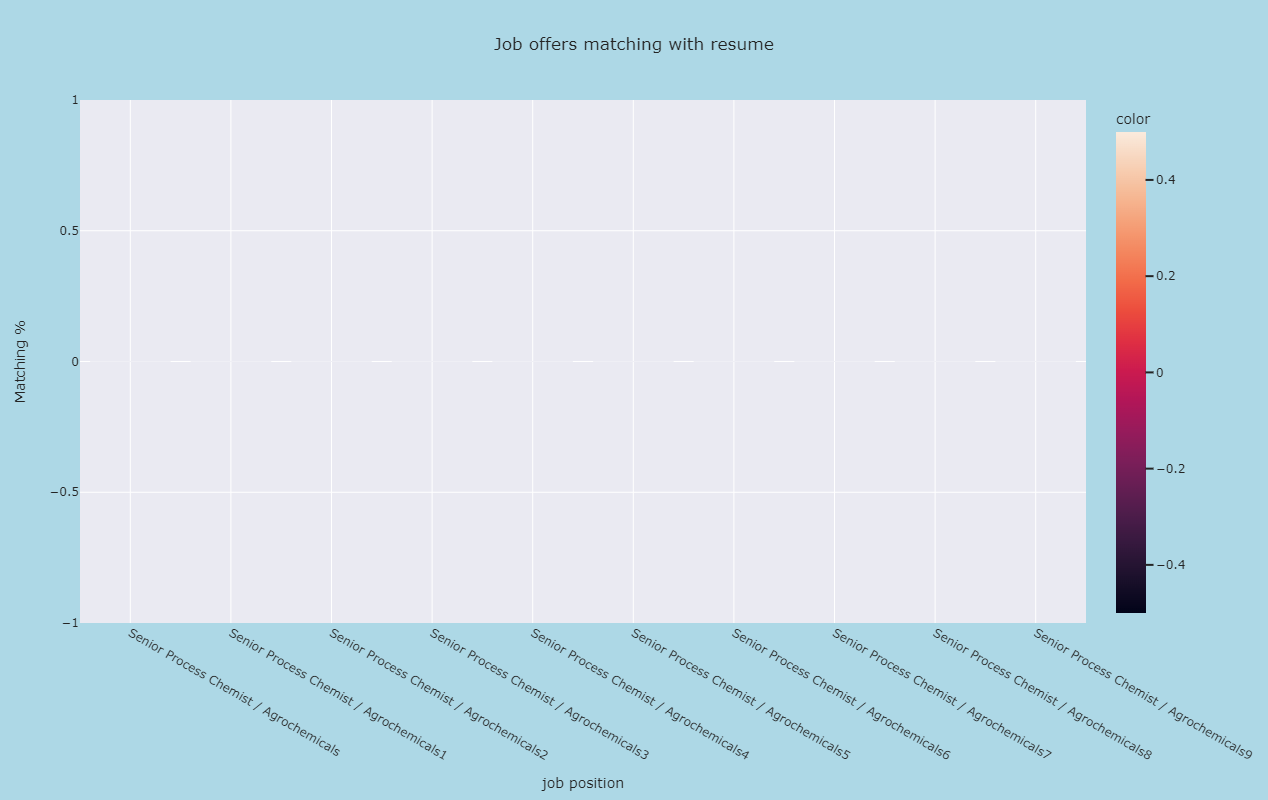

In [281]:
cv_set = skill_list
pct_list = match_skills(JD_set, cv_set, data)
pct_list

In [226]:
def match_skills(JD_set, cv_set, data):
    '''Get intersection of resume skills and job offer skills and return match percentage'''
    pct_list = []
    
    JD_set = list(filter(None, JD_set))
    if len(cv_set) < 1:
        print('could not extract skills from resume text')   
    else:
        #implement function comparing with a list of job_descriptions
        for i in range(0, len(JD_set)):
            if len(JD_set) == 0:
                continue
            #match = set(cv_set) & JD_set[i] 
            qu = len(set(cv_set) & JD_set[i])
            di = len(JD_set[i])
            pct_match = round((qu/di) * 100, 2)
            pct_list.append([i, pct_match])
            
        pct_list.sort(key=lambda x: x[1], reverse = True)
        pct_list = pct_list[0:10]
        
    '''Counting matching score'''
    job_number, matching_score, job_cat = [], [], []
    frame = pd.DataFrame

    for i in pct_list:
        cat = data["position"][i[0]]
        sec = data["job"][i[0]]
        print('Job as {} in Sector {} has a {}% match'.format(cat, sec, i[1]))
        #job_number.append(i[0])
        matching_score.append(i[1])

        if cat in job_cat:
            job_cat.append(str(cat) + str(i[0]))
        else:
            job_cat.append(cat)

    frame = pd.DataFrame(job_number, columns=['job_number'])
    frame["matching_score"] = matching_score
    frame["Category"] = job_cat

    
    #Visualizing with plotly
    #for template in ["ggplot2", "seaborn"]:

    fig = px.bar(
        x=frame['Category'], 
        y=frame["matching_score"],
        labels={"x": "job position", "y": "Matching %"},
        title=f"Job offers matching with resume",
        width=1200, height=800,
        template="seaborn",
        color = frame["matching_score"])
    fig.update_layout(
            #margin=dict(l=20, r=20, t=20, b=20),
        paper_bgcolor="lightblue",
    )
    
    return fig.show()

In [47]:
#different cleaning function
def clean_resume(df):
    clean = []
    for i in range(df.shape[0]):
        review = re.sub(
            '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
            " ",
            df["Resume_str"].iloc[i],
        )
        review = review.lower()
        review = review.split()
        lm = WordNetLemmatizer()
        review = [
            lm.lemmatize(word)
            for word in review
            if not word in set(stopwords.words("english"))
        ]
        review = " ".join(review)
        clean.append(review)
    return clean

In [247]:
#create skill_set from entity_ruler
def create_skill_list(text, model = False):
    
    if model == True:
        
        skill_pattern_path = PATH_COMPLETE_DICT
        nlp_ms = spacy.blank("en")
        ruler = nlp_ms.add_pipe("entity_ruler")
        ruler.from_disk(skill_pattern_path)
        doc = nlp_ms(text)
    else:
        doc = text
    
    t = list([ent.text.lower()] for ent in doc.ents )
    flat_list = [item for sublist in t for item in sublist]
    return set(flat_list)

In [248]:
def get_dict_cv(x):
    dict_ = {}
    entities = extract_entities_2(x['entities_manual_label'])
    labels = extract_lables(x['entities_manual_label'])
    for index, key in enumerate(entities):
        if key not in dict_.keys():
            dict_[key] = labels[index]
    entities_manual_label = extract_skills_auto(x['entity_ruler'])
    for index, value in enumerate(entities_manual_label):
        if value not in dict_.keys():
            dict_[value] = 'SKILL'
    skills_list = []
    for entity, label in dict_.items():
        if label == 'SKILL':
            skills_list.append(entity)
    x["SKILL"] = skills_list
    return x

# Unused code

In [ ]:
job_number, matching_score, job_cat = [], [], []

for i in pct_list:
    cat = df["Category"][i[0]]
    print('Job #{} in Sector {} has a {}% match'.format(i[0], df["Category"][i[0]], i[1]))
    job_number.append(i[0])
    matching_score.append(i[1])
    
    if cat in job_cat:
        job_cat.append(str(cat) + str(i[0]))
    
frame = pd.DataFrame(job_number, columns=['job_number'])
frame["matching_score"] = matching_score
frame["Category"] = df["Category"][i[0]]

In [ ]:
    ## compare list with data_set, visualize highest matching jobs
def 
    job_number, matching_score, job_cat = [], [], []
    frame = pd.DataFrame

    for i in pct_list:
        cat = data_cleaned_small["position"][i[0]]
        print('Job #{} in Sector {} has a {}% match'.format(i[0], cat, i[1]))
        job_number.append(i[0])
        matching_score.append(i[1])

        if cat in job_cat:
            job_cat.append(str(cat) + str(i[0]))
        else:
            job_cat.append(cat)

    frame = pd.DataFrame(job_number, columns=['job_number'])
    frame["matching_score"] = matching_score
    frame["Category"] = job_cat


    #for template in ["ggplot2", "seaborn"]:
    import plotly.graph_objects as go

    fig = px.bar(
        x=frame['Category'], 
        y=frame["matching_score"],
        labels={"x": "job position", "y": "Matching %"},
        title=f"Job offers matching with resume",
        width=1200, height=800,
        template="seaborn",
        color = frame["matching_score"])
    fig.update_layout(
            #margin=dict(l=20, r=20, t=20, b=20),
        paper_bgcolor="lightblue",
    )
    fig.show()

In [ ]:
#functions for getting entities text, label, start and end of character position
"""def create_skill_set(text, model = False):
    '''Apply basic spacy model and Create a set of the extracted skill entities'''
    
    if model == True:
        nlp_ms = spacy.blank("en")
        skill_pattern_path = PATH + "/data/dictionaries/complete_dict.jsonl"
        ruler = nlp_ms.add_pipe("entity_ruler")
        ruler.from_disk(skill_pattern_path)
        doc = nlp(text)
    else:
        doc = text
        
    return set([ent.label_.upper()[6:] for ent in doc.ents if 'skill' or 'knowledge' in ent.label_.lower()])
"""

In [ ]:
fig = px.histogram(
    df, x="Category", title="Distribution of Jobs Categories"
).update_xaxes(categoryorder="total descending")
fig.show()